In [2]:
''' 

Submitter : JESOON KANG, 20170937
Date : 2019. 10. 


    Assignment 4. 

-   -


'''
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torchvision
import os


In [3]:

#### Section 1. #### This Section is bringed Data_import_ex.py file.

# Image Data import & resize

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = '../data/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)  


validation_data_path = '../data/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True, num_workers=0)  

#### Section 1 END ####


In [4]:

# sigmoid Function.
def sigmoid(z) :
    return 1 / (1 + torch.pow(math.e,-z)+0.000001)

def tanh(z) :
    ret = (2 / (1 + torch.pow(math.e,-2*z) + 0.000001)) - 1
    return ret

def derv_tanh(z) :
    ret = (1 - (tanh(z)**2))
    return ret

def relu(z) :
    ret = z.clone().detach()
    #print(ret)
    tmp = torch.zeros_like(ret)
    ret = torch.where(ret<=0,tmp,ret)
    return ret
                                                                  
def derv_relu(z) :
    ret = z.clone().detach()
    tmp_1 = torch.zeros_like(ret)
    tmp_2 = torch.ones_like(ret)
    ret = torch.where(ret<0,tmp_1,tmp_2)
    #print(ret)
    return ret
    
            
def leakly_relu(z) :
    ret = z.clone().detach()
    tmp1 = torch.ones_like(ret)
    ret = torch.where(ret<0,ret*0.01,ret)
    return ret

def derv_leakly_relu(z) :
    ret = z.clone().detach()
    tmp1 = torch.ones_like(ret)
    ret = torch.where(ret<0, tmp1*0.01,tmp1)
    
    return ret

def get_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)
    elif (type == 1) :
        return tanh(z)
    elif (type == 2) :
        return relu(z)
    elif (type == 3) :
        return leakly_relu(z)
    
    else :
        print("Error, get_activation")
        return 0

def get_derv_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)*(1-sigmoid(z))
    elif (type == 1) :
        return derv_tanh(z)
    elif (type == 2) :
        return derv_relu(z)
    elif (type == 3) :
        return derv_leakly_relu(z)    
    else :
        print("Error, get_derv_activation")
        return 0                                                                  

In [5]:
def get_loss(y,a) :
    #print(y,a)
    ret = -(torch.div(y,a+0.000001) - torch.div(1-y,1-a+0.000001))
    
    return ret

BATCH_SIZE = 100
FEATURE_SIZE = 10000
class ML :
    def __init__(self,act1,act2,act3,L1_size,L2_size,L3_size,lr,min_loss_diff) :
        self.act_type_1 = act1
        self.act_type_2 = act2
        self.act_type_3 = act3 
        self.l1_size = L1_size
        self.l2_size = L2_size
        self.l3_size = L3_size
        self.feature_size = 10000
        self.epoch = 0
        self.lr = lr
        self.min_loss_diff = min_loss_diff
        
        self.init_weights()
        
        print("ML Object initialized")
        self.iter = 0

        self.val_acc_log = []
        self.val_loss_log = []
        self.train_acc_log = []
        self.train_loss_log = []
        self.epoch_log = []
        self.val_acc_log.append(0)
        self.val_loss_log.append(0)
        self.train_acc_log.append(0)
        self.train_loss_log.append(0)
        self.epoch_log.append(0)
        
    def init_weights(self) :
        self.w_1 = torch.FloatTensor(self.l1_size,self.feature_size).uniform_(-1,1)
        self.b_1 = torch.FloatTensor(1,self.l1_size).uniform_(-1,1)
        
        #torch.FloatTensor(a, b).uniform_(r1, r2)
        
        self.w_2 = torch.FloatTensor(self.l2_size,self.l1_size).uniform_(-1,1)
        self.b_2 = torch.FloatTensor(1,self.l2_size).uniform_(-1,1)

        self.w_3 = torch.FloatTensor(self.l3_size,self.l2_size).uniform_(-1,1)
        self.b_3 = torch.FloatTensor(1,self.l3_size).uniform_(-1,1)

        

        
    def training(self) :
        
        epoch = 0
        for epoch in range(0,1000000):
            train_acc_log_tmp = []
            train_loss_log_tmp = []
            val_acc_log_tmp = []
            val_loss_log_tmp = []
            

        # load training images of the batch size for every iteration
            for i, data in enumerate(trainloader):
                
                # inputs is the images
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]

                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.t_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.t_data_batch = self.t_data_batch.view(len(data[0]),FEATURE_SIZE)
                self.z_1 = torch.matmul(self.t_data_batch,self.w_1.T) + self.b_1
                #print(self.z_1)
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)
                
                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2

                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                #print(self.z_3)
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1
            
                #print(self.a_3)
                self.t_yh_batch = data[1].float().unsqueeze(1)

                #print(self.a_3,self.t_yh_batch)
                acc = self.get_acc(self.a_3,self.t_yh_batch)
                loss = np.array(get_loss(self.t_yh_batch, self.a_3)).mean()
                
                train_acc_log_tmp.append(acc)
                train_loss_log_tmp.append(loss)
                
                self.update_weights(self.t_yh_batch,self.a_3)
            
            
            
            train_acc = np.array(train_acc_log_tmp).mean()
            train_loss = np.array(train_loss_log_tmp).mean()

            print("epoch : %s, loss : %s, tra_acc : %s"%(epoch,train_loss,train_acc))
            
           

            # load validation images of the batch size for every iteration
            for i, data in enumerate(valloader):

                # inputs is the image
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]
                
                
                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.v_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.v_data_batch = self.v_data_batch.view(len(data[0]),FEATURE_SIZE)
                
                self.z_1 = torch.matmul(self.v_data_batch,self.w_1.T) + self.b_1
                
                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)

                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2
                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1

                self.v_yh_batch = data[1].float().unsqueeze(1)
                acc = self.get_acc(self.a_3,self.v_yh_batch)
                
                
                loss = np.array(get_loss(self.v_yh_batch, self.a_3)).mean()
                val_acc_log_tmp.append(acc)
                val_loss_log_tmp.append(loss)
            val_acc = np.array(val_acc_log_tmp).mean()
            val_loss = np.array(val_loss_log_tmp).mean()
            
            print("epoch : %s, loss : %s, val_acc : %s"%(epoch,val_loss,val_acc))

            self.train_acc_log.append(train_acc)
            self.train_loss_log.append(train_loss)
            self.val_acc_log.append(val_acc)
            self.val_loss_log.append(val_loss)
            self.epoch_log.append(epoch)
            epoch += 1
            
            tmp_idx = len(self.train_loss_log)-1
            if ( abs(self.train_loss_log[tmp_idx]-self.train_loss_log[tmp_idx-1]) < self.min_loss_diff) :
                print("Learning is terminated.")
                break

        
    def update_weights(self,t_y,a_3) :
        error_wb3 = -(torch.div(t_y,a_3+ 0.00011) - torch.div(1.0-t_y,1.0-a_3+ 0.00001)) # sum ep
        d_z_3 = error_wb3*get_derv_activation(self.z_3,self.act_type_3) #         
        d_w_3 = torch.matmul(d_z_3.T,self.a_2)
        d_b_3 = torch.sum(d_z_3, dim=0, keepdim=True) / self.a_2.shape[0] # mean도 됨
        
        #########
        
        error_wb2 = torch.matmul(d_z_3,self.w_3)
        
        d_z_2 = error_wb2*get_derv_activation(self.z_2,self.act_type_2)
        
        d_w_2 = torch.matmul(d_z_2.T,self.a_1)
        d_b_2 = torch.sum(d_z_2, dim=0,keepdims=True) / self.a_1.shape[0]
        
   
        error_wb1 = torch.matmul(d_z_2,self.w_2)
        d_z_1 = error_wb1*get_derv_activation(self.z_1,self.act_type_1)
        d_w_1 = torch.matmul(d_z_1.T,self.t_data_batch)
        d_b_1 = torch.sum(d_z_1, dim=0,keepdims=True) / self.t_data_batch.shape[0]
        
        
        self.w_3 += -self.lr*d_w_3
        self.b_3 += -self.lr*d_b_3
        
        self.w_2 += -self.lr*d_w_2
        self.b_2 += -self.lr*d_b_2
        self.w_1 += -self.lr*d_w_1
        self.b_1 += -self.lr*d_b_1
        #print(b_3,b_2,b_1)
        
    def get_acc(self,yhat,y) :
        count = 0
      
        for a,b in zip(yhat,y) :
            if a >= 0.5 :
                if b == 1 :
                    count+=1
            else :
                if b == 0:
                    count +=1
        
        return count / len(yhat)

    def show_loss(self) :
        #print(self.train_loss_log)
        #print(self.val_loss_log)
        #print(self.epoch_log)
        
        tmp_1 = torch.tensor(self.train_loss_log)
        tmp_2 = torch.tensor(self.epoch_log)
       
        t1 = plt.plot(self.epoch_log,self.train_loss_log, color='orange',label='Training Loss')
        t2 = plt.plot(self.epoch_log,self.val_loss_log, color= 'red',label='Validation Loss')
        plt.title("Loss")
        plt.legend(['Training Loss','Validation Loss'])
        plt.show()
    def show_acc(self) :
        t1 = plt.plot(self.epoch_log,self.train_acc_log, color='orange',label='Training Acc')
        t2 = plt.plot(self.epoch_log,self.val_acc_log, color= 'red',label='Validation Acc')
        plt.title("Accuracy")
        plt.legend(['Training Acc','Validation Acc'])
        plt.show()



In [38]:

activation_type = 0 # 0 = sigmoid
learningRate = 0.001
min_loss_diff = 0.00001


In [39]:
#1,1,0 means tanh, tanh, sigmoid
machine = ML(1,1,0,10,5,1,learningRate,min_loss_diff)




ML Object initialized


In [40]:
machine.training()

epoch : 0, loss : 1.0600404, tra_acc : 0.5316835016835015
epoch : 0, loss : 0.20998967, val_acc : 0.5783333333333333
epoch : 1, loss : 0.1286435, tra_acc : 0.5536026936026937
epoch : 1, loss : 0.11689044, val_acc : 0.5909523809523809
epoch : 2, loss : 0.075681455, tra_acc : 0.5575084175084176
epoch : 2, loss : 0.13972817, val_acc : 0.5711904761904762
epoch : 3, loss : 0.012391556, tra_acc : 0.5636026936026937
epoch : 3, loss : 0.20473401, val_acc : 0.5750000000000001
epoch : 4, loss : 0.057575203, tra_acc : 0.5645117845117845
epoch : 4, loss : 0.25515535, val_acc : 0.5652380952380952
epoch : 5, loss : 0.054708634, tra_acc : 0.5605050505050505
epoch : 5, loss : 0.20659447, val_acc : 0.5738095238095238
epoch : 6, loss : 0.089015834, tra_acc : 0.5663299663299664
epoch : 6, loss : 0.23923647, val_acc : 0.565952380952381
epoch : 7, loss : 0.06586232, tra_acc : 0.5677777777777778
epoch : 7, loss : 0.18643914, val_acc : 0.5816666666666667
epoch : 8, loss : 0.115679786, tra_acc : 0.56895622895

epoch : 69, loss : 0.08756261, tra_acc : 0.75006734006734
epoch : 69, loss : 0.62764615, val_acc : 0.6642857142857143
epoch : 70, loss : 0.06347323, tra_acc : 0.7552525252525253
epoch : 70, loss : 0.31767252, val_acc : 0.7054761904761904
epoch : 71, loss : -0.02178424, tra_acc : 0.7582491582491584
epoch : 71, loss : 0.32279533, val_acc : 0.7254761904761905
epoch : 72, loss : 0.0026024987, tra_acc : 0.7656228956228955
epoch : 72, loss : 0.31505424, val_acc : 0.7347619047619047
epoch : 73, loss : 0.035097566, tra_acc : 0.763164983164983
epoch : 73, loss : 0.53873384, val_acc : 0.6935714285714285
epoch : 74, loss : 0.022917138, tra_acc : 0.7656228956228955
epoch : 74, loss : 0.7362716, val_acc : 0.649047619047619
epoch : 75, loss : 0.015087899, tra_acc : 0.7657912457912459
epoch : 75, loss : 0.44290745, val_acc : 0.7207142857142858
epoch : 76, loss : 0.05692806, tra_acc : 0.775892255892256
epoch : 76, loss : 0.60673106, val_acc : 0.6549999999999999
epoch : 77, loss : 0.019104201, tra_acc 

epoch : 137, loss : -0.05698764, tra_acc : 0.8456228956228955
epoch : 137, loss : 0.5991989, val_acc : 0.7785714285714285
epoch : 138, loss : -0.081359595, tra_acc : 0.8486195286195286
epoch : 138, loss : 0.60158515, val_acc : 0.8116666666666666
epoch : 139, loss : 0.1361811, tra_acc : 0.8383501683501682
epoch : 139, loss : -0.111544706, val_acc : 0.8059523809523809
epoch : 140, loss : 0.063775435, tra_acc : 0.8265319865319865
epoch : 140, loss : 0.24329431, val_acc : 0.8004761904761905
epoch : 141, loss : -0.078783445, tra_acc : 0.861077441077441
epoch : 141, loss : 0.80953884, val_acc : 0.787142857142857
epoch : 142, loss : -0.18299872, tra_acc : 0.8247138047138045
epoch : 142, loss : 0.47476968, val_acc : 0.8211904761904761
epoch : 143, loss : 0.004155156, tra_acc : 0.8458922558922559
epoch : 143, loss : 0.42474818, val_acc : 0.8242857142857143
epoch : 144, loss : 0.18384886, tra_acc : 0.8130639730639732
epoch : 144, loss : 0.35013548, val_acc : 0.7826190476190477
epoch : 145, loss 

epoch : 205, loss : 0.038754188, tra_acc : 0.8892592592592592
epoch : 205, loss : 1.449732, val_acc : 0.8104761904761905
epoch : 206, loss : 0.04967328, tra_acc : 0.8838047138047138
epoch : 206, loss : 2.2613134, val_acc : 0.7466666666666667
epoch : 207, loss : 0.25759804, tra_acc : 0.8753535353535354
epoch : 207, loss : -0.31673375, val_acc : 0.8385714285714285
epoch : 208, loss : 0.058992602, tra_acc : 0.8887205387205387
epoch : 208, loss : -0.05188327, val_acc : 0.8476190476190476
epoch : 209, loss : -0.07186897, tra_acc : 0.8895286195286196
epoch : 209, loss : 0.334837, val_acc : 0.8304761904761904
epoch : 210, loss : -0.050565198, tra_acc : 0.9032659932659932
epoch : 210, loss : -0.023591796, val_acc : 0.8564285714285714
epoch : 211, loss : -0.1552613, tra_acc : 0.8943434343434343
epoch : 211, loss : -0.40450802, val_acc : 0.815952380952381
epoch : 212, loss : 0.034336373, tra_acc : 0.8662626262626264
epoch : 212, loss : 0.7942701, val_acc : 0.8304761904761904
epoch : 213, loss : 

epoch : 273, loss : 0.073414415, tra_acc : 0.9162626262626262
epoch : 273, loss : -0.036461134, val_acc : 0.849047619047619
epoch : 274, loss : 0.040009547, tra_acc : 0.9120875420875424
epoch : 274, loss : -0.110415995, val_acc : 0.8423809523809523
epoch : 275, loss : 0.0027586399, tra_acc : 0.9144444444444445
epoch : 275, loss : -0.63844615, val_acc : 0.8204761904761906
epoch : 276, loss : -0.008051076, tra_acc : 0.9175420875420875
epoch : 276, loss : 0.8194508, val_acc : 0.8238095238095239
epoch : 277, loss : 0.031651877, tra_acc : 0.9159932659932661
epoch : 277, loss : 0.6902208, val_acc : 0.8304761904761904
epoch : 278, loss : 0.039938867, tra_acc : 0.9190909090909092
epoch : 278, loss : -0.13558741, val_acc : 0.8390476190476192
epoch : 279, loss : 0.087139994, tra_acc : 0.9305387205387206
epoch : 279, loss : -0.69809777, val_acc : 0.8338095238095238
epoch : 280, loss : 0.057096288, tra_acc : 0.9235353535353535
epoch : 280, loss : 0.15194787, val_acc : 0.8483333333333333
epoch : 28

epoch : 340, loss : 0.046802424, tra_acc : 0.9511784511784512
epoch : 340, loss : -1.5409797, val_acc : 0.8192857142857143
epoch : 341, loss : 0.078923315, tra_acc : 0.9511784511784511
epoch : 341, loss : -0.7944905, val_acc : 0.8357142857142857
epoch : 342, loss : 0.024547268, tra_acc : 0.9487205387205386
epoch : 342, loss : -0.87200373, val_acc : 0.8383333333333333
epoch : 343, loss : -0.05895592, tra_acc : 0.9511784511784511
epoch : 343, loss : -1.3074065, val_acc : 0.8304761904761904
epoch : 344, loss : 0.124599345, tra_acc : 0.9438047138047139
epoch : 344, loss : -1.161167, val_acc : 0.8245238095238095
epoch : 345, loss : 0.0075810407, tra_acc : 0.9511784511784512
epoch : 345, loss : -1.4099112, val_acc : 0.8245238095238095
epoch : 346, loss : 0.043703564, tra_acc : 0.9536363636363635
epoch : 346, loss : -1.2049061, val_acc : 0.8316666666666667
epoch : 347, loss : 0.08250969, tra_acc : 0.9511784511784512
epoch : 347, loss : -0.93667036, val_acc : 0.8219047619047619
epoch : 348, lo

epoch : 408, loss : -0.005018245, tra_acc : 0.954814814814815
epoch : 408, loss : -1.5057836, val_acc : 0.8371428571428572
epoch : 409, loss : 0.03323299, tra_acc : 0.9572727272727274
epoch : 409, loss : -1.62436, val_acc : 0.8357142857142857
epoch : 410, loss : 0.081765056, tra_acc : 0.9572727272727272
epoch : 410, loss : -1.3924093, val_acc : 0.8311904761904761
epoch : 411, loss : 0.110662654, tra_acc : 0.9523569023569024
epoch : 411, loss : -1.5248405, val_acc : 0.8471428571428571
epoch : 412, loss : -0.16453002, tra_acc : 0.9523569023569024
epoch : 412, loss : -1.151543, val_acc : 0.8252380952380952
epoch : 413, loss : 0.045863118, tra_acc : 0.9572727272727272
epoch : 413, loss : -1.0443319, val_acc : 0.8450000000000001
epoch : 414, loss : 0.39796135, tra_acc : 0.9214478114478113
epoch : 414, loss : -1.7016072, val_acc : 0.855
epoch : 415, loss : -0.013848349, tra_acc : 0.9572727272727272
epoch : 415, loss : -2.47155, val_acc : 0.8230952380952381
epoch : 416, loss : 0.16372435, tra

epoch : 476, loss : 0.065222055, tra_acc : 0.9609090909090909
epoch : 476, loss : -1.2961355, val_acc : 0.8416666666666667
epoch : 477, loss : 0.1477579, tra_acc : 0.9559932659932661
epoch : 477, loss : -2.520712, val_acc : 0.8319047619047618
epoch : 478, loss : 0.0443137, tra_acc : 0.9609090909090908
epoch : 478, loss : -2.128349, val_acc : 0.8345238095238097
epoch : 479, loss : -0.026716834, tra_acc : 0.9569023569023568
epoch : 479, loss : -1.7026979, val_acc : 0.8292857142857143
epoch : 480, loss : -0.0011557381, tra_acc : 0.9584511784511786
epoch : 480, loss : -0.77694017, val_acc : 0.8450000000000001
epoch : 481, loss : -0.10291124, tra_acc : 0.9584511784511786
epoch : 481, loss : -0.94632554, val_acc : 0.8423809523809523
epoch : 482, loss : 0.018379433, tra_acc : 0.9584511784511786
epoch : 482, loss : -1.3453249, val_acc : 0.8311904761904761
epoch : 483, loss : 0.03892875, tra_acc : 0.9609090909090909
epoch : 483, loss : -0.9850054, val_acc : 0.8304761904761904
epoch : 484, loss 

epoch : 543, loss : -0.0007719926, tra_acc : 0.9584511784511786
epoch : 543, loss : -0.97250533, val_acc : 0.8364285714285714
epoch : 544, loss : 0.1429448, tra_acc : 0.9541750841750843
epoch : 544, loss : -1.072318, val_acc : 0.8364285714285714
epoch : 545, loss : -0.16712882, tra_acc : 0.9167003367003368
epoch : 545, loss : 7.862695, val_acc : 0.7533333333333333
epoch : 546, loss : 0.5737928, tra_acc : 0.9393602693602694
epoch : 546, loss : 0.73055905, val_acc : 0.8495238095238097
epoch : 547, loss : 0.08651572, tra_acc : 0.9602693602693603
epoch : 547, loss : 0.6763058, val_acc : 0.8423809523809523
epoch : 548, loss : 0.1458799, tra_acc : 0.9602693602693603
epoch : 548, loss : 0.6834758, val_acc : 0.8345238095238096
epoch : 549, loss : 0.012472718, tra_acc : 0.9505387205387205
epoch : 549, loss : 0.65493315, val_acc : 0.8476190476190476
epoch : 550, loss : 0.090639725, tra_acc : 0.9569023569023568
epoch : 550, loss : -0.11368084, val_acc : 0.8476190476190476
epoch : 551, loss : 0.06

epoch : 610, loss : -0.022198321, tra_acc : 0.962996632996633
epoch : 610, loss : -1.0205476, val_acc : 0.8390476190476189
epoch : 611, loss : 0.046893235, tra_acc : 0.9654545454545453
epoch : 611, loss : -1.2783114, val_acc : 0.8311904761904761
epoch : 612, loss : -0.003705266, tra_acc : 0.962996632996633
epoch : 612, loss : -0.3912052, val_acc : 0.8469047619047618
epoch : 613, loss : 0.08521497, tra_acc : 0.9654545454545453
epoch : 613, loss : -0.9532728, val_acc : 0.8416666666666667
epoch : 614, loss : 0.02355989, tra_acc : 0.9654545454545453
epoch : 614, loss : -0.006578684, val_acc : 0.8311904761904761
epoch : 615, loss : 0.07047364, tra_acc : 0.9605387205387206
epoch : 615, loss : -0.39397213, val_acc : 0.8338095238095238
epoch : 616, loss : 0.044232108, tra_acc : 0.9636363636363636
epoch : 616, loss : 0.09433317, val_acc : 0.8311904761904761
epoch : 617, loss : 0.06473251, tra_acc : 0.9629966329966332
epoch : 617, loss : -0.35903016, val_acc : 0.8442857142857143
epoch : 618, los

epoch : 677, loss : 0.1705214, tra_acc : 0.9629966329966332
epoch : 677, loss : -0.37817863, val_acc : 0.8285714285714286
epoch : 678, loss : 0.053210497, tra_acc : 0.9605387205387204
epoch : 678, loss : -0.70634884, val_acc : 0.8416666666666667
epoch : 679, loss : 0.00063669885, tra_acc : 0.9620875420875422
epoch : 679, loss : -0.33413568, val_acc : 0.8259523809523809
epoch : 680, loss : 0.039470773, tra_acc : 0.962996632996633
epoch : 680, loss : 0.028233727, val_acc : 0.8285714285714286
epoch : 681, loss : 0.18621899, tra_acc : 0.962996632996633
epoch : 681, loss : -0.4444684, val_acc : 0.8390476190476189
epoch : 682, loss : 0.089408025, tra_acc : 0.9580808080808082
epoch : 682, loss : -0.2371347, val_acc : 0.8442857142857143
epoch : 683, loss : 0.17922948, tra_acc : 0.9556228956228956
epoch : 683, loss : -1.10321, val_acc : 0.8390476190476189
epoch : 684, loss : 0.031696506, tra_acc : 0.9605387205387206
epoch : 684, loss : -0.21988048, val_acc : 0.8364285714285714
epoch : 685, loss

epoch : 744, loss : 0.16524118, tra_acc : 0.963905723905724
epoch : 744, loss : -0.010154049, val_acc : 0.8390476190476189
epoch : 745, loss : 0.05840172, tra_acc : 0.9663636363636363
epoch : 745, loss : -0.36797032, val_acc : 0.8469047619047618
epoch : 746, loss : -0.0016568283, tra_acc : 0.963905723905724
epoch : 746, loss : 0.7981369, val_acc : 0.8338095238095238
epoch : 747, loss : 0.04584009, tra_acc : 0.9589898989898991
epoch : 747, loss : 0.031410098, val_acc : 0.8423809523809523
epoch : 748, loss : 0.12247815, tra_acc : 0.963905723905724
epoch : 748, loss : 0.23670013, val_acc : 0.8364285714285714
epoch : 749, loss : 0.04208955, tra_acc : 0.9663636363636363
epoch : 749, loss : -0.10849481, val_acc : 0.8442857142857143
epoch : 750, loss : 0.073551826, tra_acc : 0.963905723905724
epoch : 750, loss : -0.59520096, val_acc : 0.8364285714285714
epoch : 751, loss : 0.06611803, tra_acc : 0.963905723905724
epoch : 751, loss : -1.2722102, val_acc : 0.8338095238095239
epoch : 752, loss : 

KeyboardInterrupt: 

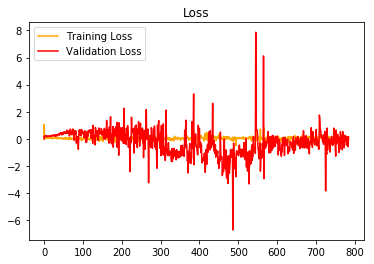

In [41]:
machine.show_loss()


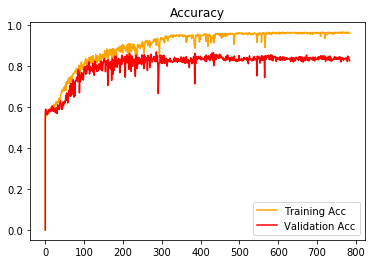

In [42]:
machine.show_acc()